In [193]:
!pip install xgboost

In [1]:
%load_ext autoreload
%autoreload 2

In [220]:
import keras
import pandas as pd
import os
import importlib
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics
from keras.callbacks import History
import seaborn as sns
import xgboost as xgb

try:
    os.chdir('py')
except FileNotFoundError:
    pass
import small
from small import Splits as S
from small import relu
_ = importlib.reload(small)

In [87]:
sns.set()
sns.set_style("whitegrid")

In [226]:
handler = small.ServoHandler()
df = handler.read()

In [227]:
datasets = handler.split_and_apply_transforms(df)

In [235]:
keras.backend.clear_session()
relus = small.make_relu_stack(datasets[S.trn]['X'].shape[1], step=1)
layers = small.interleave_dropout(relus, input_dropout=0.0, hidden_dropout=0.05)
model = keras.Sequential(layers)
model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError())

In [ ]:
epochs = 1000
batch_size = 16 * 4
history = model.fit(
    datasets[S.trn]['X'], datasets[S.trn]['y'], 
    epochs=epochs, 
    batch_size=batch_size, 
    callbacks=[History()], 
    verbose=1,
    validation_data=(datasets[S.val]['X'], datasets[S.val]['y']))

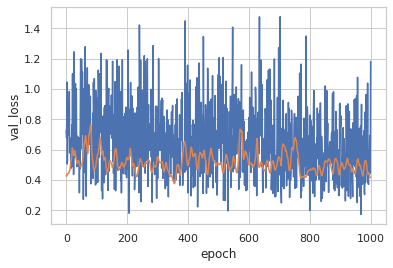

In [240]:
loss_df = pd.DataFrame(history.history)
loss_df['epoch'] = range(loss_df.shape[0])
_ = sns.lineplot(x='epoch', y='loss', data=loss_df)
_ = sns.lineplot(x='epoch', y='val_loss', data=loss_df)

In [244]:
evaluator = small.RegressionEvaluator(datasets, sklearn.metrics.mean_squared_error)
metrics = {}
for m in small.Regressor:
    model_to_evaluate = m.value()
    metric_value = evaluator.evaluate_regressor(model_to_evaluate)
    metrics[m.name] = metric_value

In [245]:
metrics

{'Linear': 1.7966273540776958,
 'RandomForest': 0.48328338221603423,
 'XGBoost': 0.18806894483514802}

In [203]:
m = xgb.sklearn.XGBRegressor()
m

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

In [241]:
nn_pred = model.predict(datasets[S.val]['X'])
sklearn.metrics.mean_squared_error(nn_pred, datasets[S.val]['y'])

0.4154997081514983